In [1]:
from sqlalchemy import create_engine

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import StanfordNERTagger

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

import nltk
import string

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


#own Kmeans
from kmeans_algorithm import Kmeans

In [2]:
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [3]:
stringDB = "mysql+pymysql://root:@localhost:3306/oerintegrationdb"
# Conexion a la BD
engine = create_engine(stringDB)

In [4]:
query = "SELECT * FROM cleantriple where predicate = 'title' limit 10;"
df = pd.read_sql(query, engine)
df

,subject,subject_alternative,predicate,object,repository
0,https://oer.galileo.usg.edu/mathematics-textbo...,,title,Armstrong Calculus,Galileo Open
1,https://oer.galileo.usg.edu/education-textbooks/3,,title,Arts Integration in Elementary Curriculum: 2nd...,Galileo Open
2,https://oer.galileo.usg.edu/english-textbooks/19,,title,Becoming America: An Exploration of American L...,Galileo Open
3,https://oer.galileo.usg.edu/english-textbooks/20,,title,Brehe's Grammar Anatomy,Galileo Open
4,https://oer.galileo.usg.edu/english-textbooks/16,,title,British Literature II: Romantic Era to the Twe...,Galileo Open
5,https://oer.galileo.usg.edu/english-textbooks/17,,title,British Literature I: Middle Ages to the Eight...,Galileo Open
6,https://oer.galileo.usg.edu/english-textbooks/14,,title,College ESL Writers: Applied Grammar and Compo...,Galileo Open
7,https://oer.galileo.usg.edu/english-textbooks/2,,title,Compact Anthology of World Literature,Galileo Open
8,https://oer.galileo.usg.edu/english-textbooks/18,,title,Compact Anthology of World Literature II: Volu...,Galileo Open
9,https://oer.galileo.usg.edu/health-textbooks/4,,title,"Concepts of Fitness and Wellness, 2nd Edition",Galileo Open


In [7]:
data = df['object']
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
#print(tf_idf)
tf_idf_norm = normalize(tf_idf)
#print(tf_idf_norm)
tf_idf_array = tf_idf_norm.toarray()
#print(tf_idf_vectorizor.get_feature_names())
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

{'Arts Integration in Elementary Curriculum: 2nd Edition', "Brehe's Grammar Anatomy", 'Armstrong Calculus', 'Compact Anthology of World Literature II: Volumes 4, 5, and 6', 'British Literature I: Middle Ages to the Eighteenth Century and Neoclassicism', 'British Literature II: Romantic Era to the Twentieth Century and Beyond', 'Concepts of Fitness and Wellness, 2nd Edition', 'College ESL Writers: Applied Grammar and Composing Strategies for Success', 'Becoming America: An Exploration of American Literature from Precolonial to Post-Revolution', 'Compact Anthology of World Literature'}


,2nd,ages,america,american,anatomy,anthology,applied,armstrong,arts,brehe,...,precolonial,revolution,romantic,strategies,success,twentieth,volumes,wellness,world,writers
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.707107,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.364296,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.428537,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.396756,0.396756,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.396756,0.396756,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.000000,0.606043,0.0,0.0,0.000000,0.000000,0.606043,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.425606,0.0,0.0,0.425606,0.0,0.0,0.0,0.0


Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


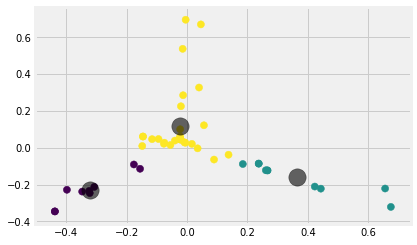

In [11]:
#Implementación propia
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

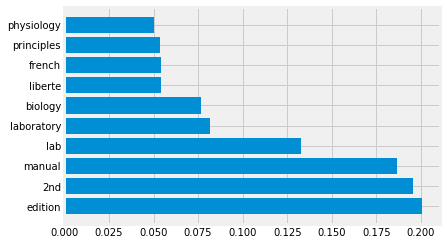

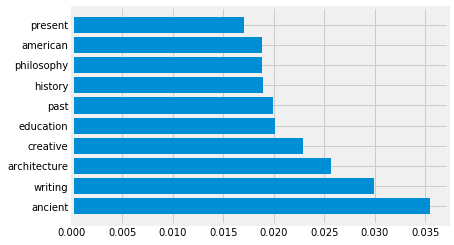

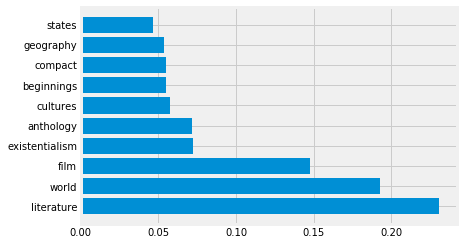

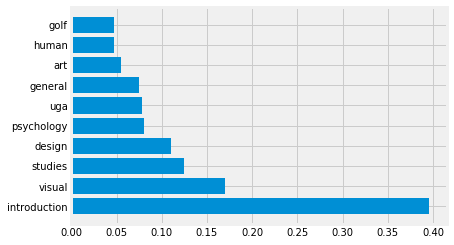

In [7]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(predicted_values)
    dfs = []
    for label in labels:
        id_temp = np.where(predicted_values==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, predicted_values,10)
for d in dfs:
    height = [h[1] for h in d.values]
    bars = [h[0] for h in d.values]
    y_pos = np.arange(len(bars))
    plt.barh(y_pos, height)
    plt.yticks(y_pos, bars)
    plt.show()